In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import fbeta_score, make_scorer, recall_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score

In [2]:
topics_filename = 'lda_data50b_all.csv'
train_filename = 'train.csv'
data_ncol = 100

In [3]:
df = pd.read_csv(topics_filename, header=None)
df = df.drop(data_ncol,1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.213649,0.0,0.000000,0.206866,0.0000,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.204375,0.0,0.000,0.000000,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.2388,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,0.34,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.244562,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.109491,0.000000,0.0000,0.374421,0.00,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.255,0.000000,0.0,0.0


In [4]:
df_text = pd.read_csv("train.csv").fillna("")
df_text.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
X = df.values
y = df_text.iloc[:,-1:].values.ravel()
del df_text

In [6]:
print len(X[0]), len(y)

100 404290


In [7]:
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.33, random_state=42)
X_train = normalize(X_train)
X_test = normalize(X_test)

In [ ]:
# Set the parameters by cross-validation

loss = ['hinge', 'log', 'modified_huber', 'squared_hinge']
shuffle = [False, True]
class_wt = [None, 'balanced']

tuned_parameters = {'loss':loss , 'shuffle' : shuffle,
                    'class_weight': class_wt, 'n_jobs': [-1]}

scores = ['precision', 'recall', 'f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print

    clf = GridSearchCV(SGDClassifier(), tuned_parameters, cv=10,                        
                     scoring='%s' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print
    print(clf.best_params_)
    print
    print("Grid scores on development set:")
    print
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print

    print("Detailed classification report:")
    print
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print

In [40]:
clf = SGDClassifier(loss = 'modified_huber', n_jobs = -1, 
                    shuffle = True, class_weight = 'balanced',
                   n_iter = 1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print confusion_matrix(y_test, y_pred)
print accuracy_score(y_test, y_pred)

[[50606 33369]
 [16739 32702]]
0.624422857828


In [41]:
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [42]:
y_pred_prob = [i[1] for i in clf.predict_proba(X_test)]

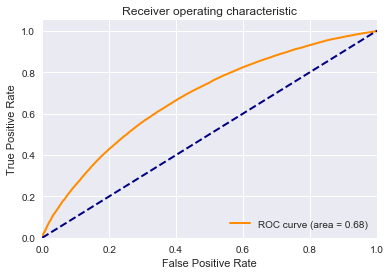

In [43]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [44]:
# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

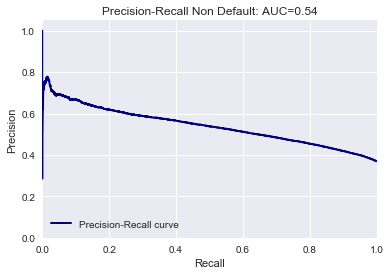

In [45]:
# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Non Default: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()

In [34]:
clf = SGDClassifier(loss = 'log', n_jobs = -1, 
                    shuffle = True, class_weight = None, n_iter = 1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print confusion_matrix(y_test, y_pred)
print accuracy_score(y_test, y_pred)

[[76390  7585]
 [37685 11756]]
0.660685375067


In [35]:
y_pred_prob = [i[1] for i in clf.predict_proba(X_test)]

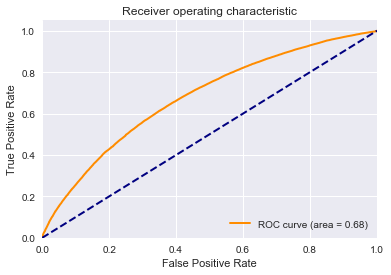

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [37]:
# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

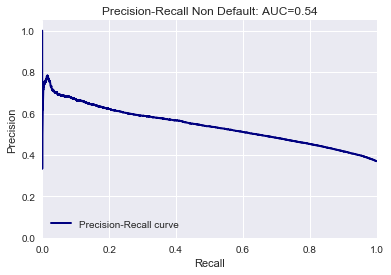

In [39]:
# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Non Default: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()